# APRENDIZAJE AUTOMÁTICO
# Práctica 3: Regresión Logística Binaria
### Autor: Jiménez Omeñaca, David
### NIP:   825068
### Fecha: 24/02/2025
---


## Configuración

In [3]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab")
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/Aprendizaje/' # Directorio donde guardas los ficheros
except:
  print("Trabajando en local")
  Path = 'data/'                                    # Directorio donde guardas los ficheros

Trabajando en local


---
## 0. Visualización de datos

c:\Users\david\Desktop\Automatic-Learning\Lab-01\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


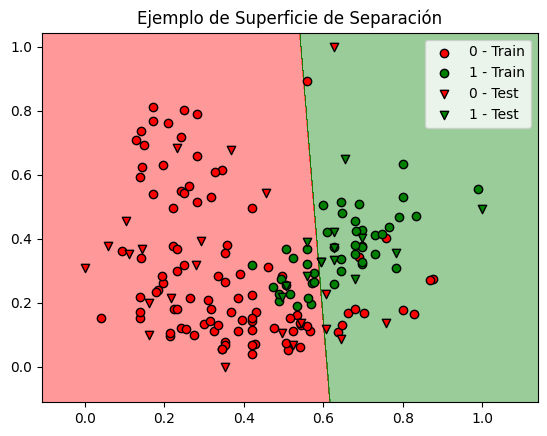

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

# Función para dibujar la superficie de separación de un clasificador con 2 clases y 2 atributos
def dibujar_clasificador(clf, X_train, y_train, X_test, y_test):
    colores = ListedColormap(["r", "g"])
    DecisionBoundaryDisplay.from_estimator(clf, X_train, eps = 0.15, cmap=colores, grid_resolution=1000, response_method="predict", alpha=0.4)
    plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c= "r", edgecolors="k", label='0 - Train')
    plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c= "g", edgecolors="k", label='1 - Train')
    plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1],  c= "r", marker = 'v', edgecolors="k", label='0 - Test')
    plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1],  c= "g", marker = 'v', edgecolors="k", label='1 - Test')
    plt.legend()

# Leer los ficheros de datos y pasarlos a matrices de numpy
data_train = pd.read_csv(Path+'wine_train.csv', sep = ";")
x1_train = data_train["f6"].to_numpy().reshape(-1, 1)
x2_train = data_train["f10"].to_numpy().reshape(-1, 1)
y_train  = data_train["Clase"].to_numpy()
X_train = np.c_[x1_train, x2_train]
y_train[y_train!=1]=0  # Transformar y en 0/1 Para clasificación binaria de la clase 1

data_test  = pd.read_csv(Path+'wine_test.csv',  sep = ";")
x1_test = data_test["f6"].to_numpy().reshape(-1, 1)
x2_test = data_test["f10"].to_numpy().reshape(-1, 1)
y_test  = data_test["Clase"].to_numpy()
X_test  = np.c_[x1_test, x2_test]
y_test[y_test!=1]=0   # Transformar y en 0/1 Para clasificación binaria de la clase 1

# Ejemplo de dibujar una superficie de separación
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(max_iter=1)
clf.fit(X_train, y_train)
dibujar_clasificador(clf, X_train, y_train, X_test, y_test)
plt.title("Ejemplo de Superficie de Separación")
plt.show()




Aquí explico las conclusiones que he sacado analizando los datos.

---
## 0. Setup

Comenzamos creando las clases necesarias para representar modelos

In [31]:
from enum import IntFlag
from typing import Dict
import pandas as pd

class Models:
    """
    A class to represent a collection of models and their computed metrics.

    This class is used to store, append, sort, and display metrics computed for multiple models.
    """
    
    def __init__(self):
        """
        Initializes an empty DataFrame to store model metrics.
        """
        self.df = pd.DataFrame()
    
    def append(self, model: pd.DataFrame):
        """
        Appends a new model's metrics to the collection.

        Parameters
        ----------

        model (pd.DataFrame) : A DataFrame containing the metrics of a single model.
        """
        self.df = pd.concat([self.df, model], axis=0, ignore_index=True)
    
    def sort(self, by: str, ascending: bool = True):
        """
        Sorts the stored models by a specified column.

        Parameters
        ----------

        by (str) : The column name by which to sort the models.
        ascending (bool, optional) : Whether to sort in ascending order. Defaults to True.
        """
        self.df = self.df.sort_values(axis=0, ascending=ascending, by=by)
    
    def print(self) -> pd.DataFrame:
        """
        Returns the stored DataFrame of model metrics.

        Returns
        -------

        pd.DataFrame : The DataFrame containing all appended model metrics.
        """
        return self.df


class ClassificationMetricsFlags(IntFlag):
    """
    Class to represent which error metrics to compute in a Linear Regression 
    analysis.

    It supports:

    - **RMSE**: Root Mean Squared Error 
    - **MAE**: Mean Absolute Error
    - **MedAE**: Median Absolute Error
    - **MRE**: Mean Relative Error
    - **MedRE**: Median Relative Error
    - **R2**: Coefficient of Determination (R^2)
    """

    PRECISSION = 1 << 0
    RECALL = 1 << 1
    F1 = 1 << 2
    ACCURACY = 1 << 3
    BALANCED_ACCURACY = 1 << 4
    FBEETA = 1 << 5


class ClassificationMetrics():

    def __init__(self, y_real, y_pred, flags):
        self.y_real = y_real
        self.y_pred = y_pred
        self.flags = flags
    
    def Precission(self):
        TP = np.sum((self.y_real == 1) & (self.y_pred == 1))
        FP = np.sum((self.y_real == 0) & (self.y_pred == 1))
        return TP / (TP + FP)

    def Recall(self):
        TP = np.sum((self.y_real == 1) & (self.y_pred == 1))
        FN = np.sum((self.y_real == 1) & (self.y_pred == 0))
        return TP / (TP + FN)
    
    def F1(self):
        precission = self.Precission()
        recall = self.Recall()
        return 2 * (precission * recall) / (precission + recall)
    
    def Accuracy(self):
        TP = np.sum((self.y_real == 1) & (self.y_pred == 1))
        TN = np.sum((self.y_real == 0) & (self.y_pred == 0))
        return (TP + TN) / len(self.y_real)
    
    def BalancedAccuracy(self):
        TP = np.sum((self.y_real == 1) & (self.y_pred == 1))
        TN = np.sum((self.y_real == 0) & (self.y_pred == 0))
        FP = np.sum((self.y_real == 0) & (self.y_pred == 1))
        FN = np.sum((self.y_real == 1) & (self.y_pred == 0))
        return (TP / (TP + FN) + TN / (TN + FP)) / 2
    
    def FBeta(self, beta):
        precission = self.Precission()
        recall = self.Recall()
        return (1 + beta**2) * (precission * recall) / (beta**2 * precission + recall)
    
    def compute_metrics(self, name:str, r:int, beta:0.5) -> Dict[str, float]:
        metrics = {
            f'prec_{name}': [round(self.Precission(), r)] if self.flags & ClassificationMetricsFlags.PRECISSION else [],
            f'recall_{name}': [round(self.Recall(), r)] if self.flags & ClassificationMetricsFlags.RECALL else [],
            f'f1_{name}': [round(self.F1(), r)] if self.flags & ClassificationMetricsFlags.F1 else [],
            f'acc_{name}': [round(self.Accuracy(), r)] if self.flags & ClassificationMetricsFlags.ACCURACY else [],
            f'bal_acc_{name}': [round(self.BalancedAccuracy(), r)] if self.flags & ClassificationMetricsFlags.BALANCED_ACCURACY else [],
            f'fbeta_{name}': [round(self.FBeta(beta), r)] if self.flags & ClassificationMetricsFlags.FBEETA else []
        }
        return metrics

class LogisticModel():
    def __init__(self, x_train, y_train, x_test, y_test, model, metrics, name):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model = model
        self.metrics = metrics
        self.name = name

        self.model.fit(self.x_train, self.y_train)
    
    def plot_decision_boundary(self, title:str="Superficie de Separación"):
        dibujar_clasificador(self.model, self.x_train, self.y_train, self.x_test, self.y_test)
        plt.title(title)
        plt.show()
    
    def compute_metrics(self, r=2):
        y_pred_train = self.model.predict(self.x_train)
        y_pred_test = self.model.predict(self.x_test)
        train_metrics = ClassificationMetrics(self.y_train, y_pred_train, self.metrics)
        train_metrics = train_metrics.compute_metrics("train", r, 0.5)

        test_metrics = ClassificationMetrics(self.y_test, y_pred_test, self.metrics)
        test_metrics = test_metrics.compute_metrics("test", r, 0.5)

        metrics = {"Name": self.name, **train_metrics, **test_metrics}
        metrics = {a:b for (a,b) in metrics.items() if b}

        return pd.DataFrame(metrics)
    
    def plot_confusion_matrix(self):
        from sklearn.metrics import plot_confusion_matrix
        plot_confusion_matrix(self.model, self.x_test, self.y_test)
        plt.show()

    def k_fold_cross_validation(self, param_name, param_range, k=5):
        from sklearn.model_selection import GridSearchCV
        parameter_grid = {param_name: param_range}
        grid = GridSearchCV(self.model, parameter_grid, cv=k, scoring='f1', return_train_score=True)
        grid.fit(self.x_train, self.y_train)
        grid_train_errors = grid.cv_results_['mean_train_score']
        grid_test_errors = grid.cv_results_['mean_test_score']

        plt.plot(param_range, grid_train_errors, label='Train')
        plt.plot(param_range, grid_test_errors, label='Test')
        plt.legend()
        plt.show()

        return (grid.best_params_, grid.best_estimator_)
       

## 1. Métricas elegidas

Para la práctica, se han elegido las métricas: **Precisión**, **Recall**, **Accuracy**, **F1** y **Accuracy Balanceada**.

In [32]:
flags = ClassificationMetricsFlags.PRECISSION | ClassificationMetricsFlags.RECALL | ClassificationMetricsFlags.F1 | ClassificationMetricsFlags.ACCURACY | ClassificationMetricsFlags.BALANCED_ACCURACY

MODELS = Models()

## 2.Regresión logística Básica

Ahora vamos a ajustar un modelo de regresión logística básico. Ploteamos la superficie de separación

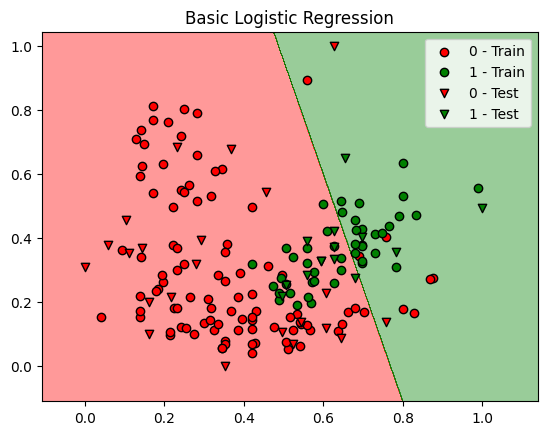

In [33]:
from sklearn.linear_model import LogisticRegression

model_1 = LogisticModel(X_train, y_train, X_test, y_test, LogisticRegression(), flags, "Basic Logistic Regression")

model_1.plot_decision_boundary("Basic Logistic Regression")

y calculamos las métricas

In [34]:
model_1.compute_metrics()

,Name,prec_train,recall_train,f1_train,acc_train,bal_acc_train,prec_test,recall_test,f1_test,acc_test,bal_acc_test
0,Basic Logistic Regression,0.76,0.49,0.59,0.79,0.71,0.67,0.29,0.4,0.67,0.6


donde podemos ver un bajo valor *F1* indicando que el modelo no es adecuado.

Ahora vamos a plotear una línea de la probabilidad de pertenecer a la clase 1 dejando el atributo 6 igual a $0.1$ y variando el atributo 10 de $0$ a $1$.

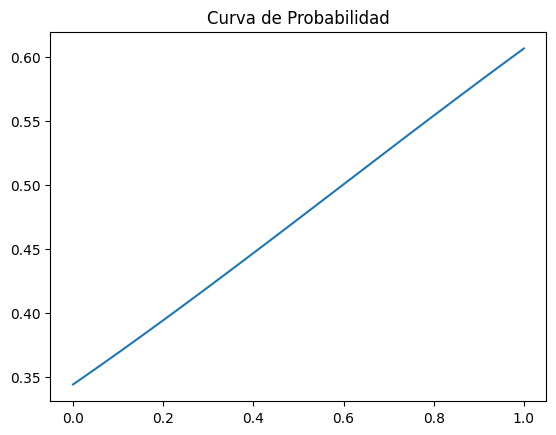

In [35]:
x_curve = np.column_stack((np.repeat(0.6,100),np.linspace(0, 1, 100)))

y_curve = model_1.model.predict_proba(x_curve)[:,1]

plt.plot(x_curve[:,1], y_curve, label="Probabilidad")
plt.title("Curva de Probabilidad")
plt.show()

Conclusiones...


## 3. Expansión de atributos

Ahora vamos a ajustar el mismo modelo con un polinomio de grado $6$ sin regularizar. Probamos con dos solvers: `liblinear` y `lbdfg`, ya que tenemos un pequeño dataset ( como se indica en [Scikit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html))

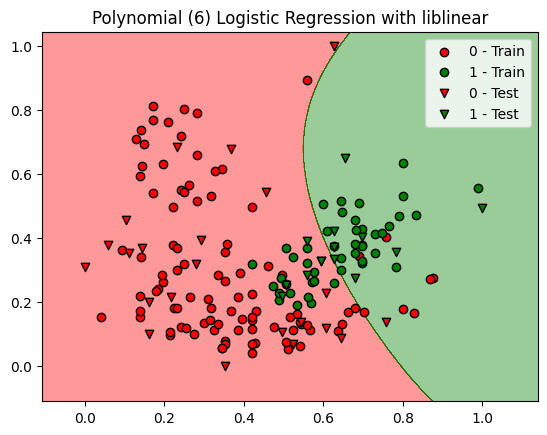

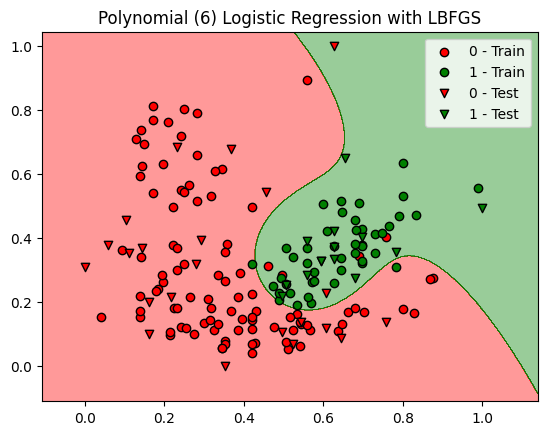

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

_mod_2_1 = make_pipeline(PolynomialFeatures(6), LogisticRegression(solver='liblinear'))
_mod_2_2 = make_pipeline(PolynomialFeatures(6), LogisticRegression(solver='lbfgs', penalty=None))

model_2_adam = LogisticModel(X_train, y_train, X_test, y_test, _mod_2_1, flags, "Polynomial (6) Logistic liblinear")
model_2_lbfgs = LogisticModel(X_train, y_train, X_test, y_test, _mod_2_2, flags, "Polynomial (6) Logistic LBFGS")

model_2_adam.plot_decision_boundary("Polynomial (6) Logistic Regression with liblinear")
model_2_lbfgs.plot_decision_boundary("Polynomial (6) Logistic Regression with LBFGS")

y las métricas:

In [41]:
pd.concat([model_2_lbfgs.compute_metrics(), model_2_adam.compute_metrics()])

,Name,prec_train,recall_train,f1_train,acc_train,bal_acc_train,prec_test,recall_test,f1_test,acc_test,bal_acc_test
0,Polynomial (6) Logistic LBFGS,0.91,0.96,0.93,0.96,0.96,0.88,1.00,0.93,0.94,0.95
0,Polynomial (6) Logistic liblinear,0.79,0.60,0.68,0.82,0.76,0.89,0.57,0.70,0.81,0.76


Conclusiones...

## Regresión Polinómica Regularizada

Ahora vamos a realizar el mismo ajuste añadiendo regularización para controlar el sobre-ajuste del modelo. Para ello, vamos a elegirlo a través de `K-Fold Validation`.

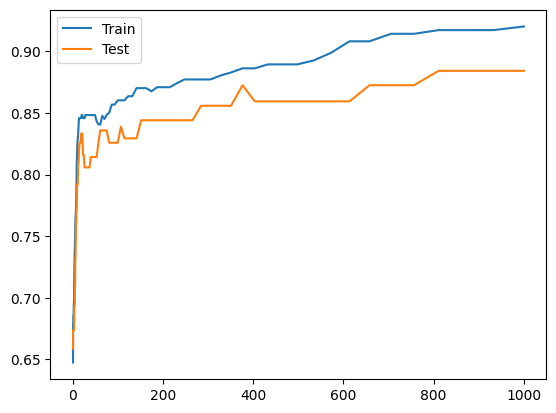

({'logisticregression__C': np.float64(811.1308307896873)},
 Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=6)),
                 ('logisticregression',
                  LogisticRegression(C=np.float64(811.1308307896873),
                                     solver='liblinear'))]))

In [48]:
_mod_3 = make_pipeline(PolynomialFeatures(6), LogisticRegression(solver='liblinear'))

model_3 = LogisticModel(X_train, y_train, X_test, y_test, _mod_3, flags, "Polynomial (6) Logistic Regression")

model_3.k_fold_cross_validation('logisticregression__C', np.logspace(0, 3, 100))